# load library

In [1]:
source("r/jupyter_common.R")

source("r/enrichment_analysis.R")
source("r/find_markers.R")
source("r/identify_cell_types.R")
source("r/plot_sc_clusters.R")


In [2]:
# data structure
suppressPackageStartupMessages(library(stringi))
suppressPackageStartupMessages(library(forcats))

# utils
suppressPackageStartupMessages(library(amap)) # for Dist()
suppressPackageStartupMessages(library(scales))

# scRNA-seq
suppressPackageStartupMessages(library(Seurat))



## parallel

In [3]:
suppressPackageStartupMessages(library(future))
plan("multicore", workers = 8)

options(future.globals.maxSize = 5 * 1024^3) # 5GB


# parameters

In [4]:
cancer_type <- "er+bc-cell-line"


args <- list()
args$cancer_type <- cancer_type
args$method_to_identify_cell_types <- "singler_blueprint_encode"
args$seurat_resolution <- 0.8
args$harmony_theta <- 0

str_column_of_meta_data_cluster <- sprintf("RNA_snn_res.%g", args$seurat_resolution)
str_column_of_meta_data_harmony <- sprintf("RNA_harmony_th.%s", paste(args$harmony_theta, collapse=","))

str_reduction <- "pca"
str_umap_reduction <- "umap"  
col_cluster_types <- "cluster.type"

str_condition <- cancer_type

str_condition
str_column_of_meta_data_cluster
str_umap_reduction
col_cluster_types

figure_format <- "pdf"




[1] "er+bc-cell-line"

[1] "RNA_snn_res.0.8"

[1] "umap"

[1] "cluster.type"

## set.seed

In [5]:
# set seed for reproducibility
set.seed(51)



## display

In [6]:
options(repr.matrix.max.cols=150, repr.matrix.max.rows=50)


## nv_cell_type_conversion_table

In [7]:
nv_cell_type_conversion_table <- c(
            "Epithelial cells"="Epi. CNA-",
            "Normal-like"="Normal-like",
            "Basal"="Basal",
            "Her2"="Her2",
            "LumA"="grpA",
            "LumB"="grpB")


# read scRNA-seq

In [8]:

dir_rna <- "/home/hkim77/spanheimer_lab.w/sc-rna-seq/tr-bc/run-20220121"
fname_rna <- sprintf("%s/output/rds_%s/%s_sc-rna-seq_merged_seurat_obj.rds",
                     dir_rna, cancer_type, cancer_type)
fname_rna

rna <- readRDS(fname_rna)



[1] "/home/hkim77/spanheimer_lab.w/sc-rna-seq/tr-bc/run-20220121/output/rds_er+bc-cell-line/er+bc-cell-line_sc-rna-seq_merged_seurat_obj.rds"

https://mojaveazure.github.io/seurat-object/reference/Seurat-methods.html

dim: The number of features (nrow) and cells (ncol) for the default assay; note: while the number of features changes depending on the active assay, the number of cells remains the same across all assays


In [9]:
class(rna)
rna

names(rna)
DefaultAssay(rna)


[1] "Seurat"
attr(,"package")
[1] "SeuratObject"

An object of class Seurat 
20470 features across 4280 samples within 1 assay 
Active assay: RNA (20470 features, 2000 variable features)
 2 dimensional reductions calculated: pca, umap

[1] "RNA"  "pca"  "umap"

[1] "RNA"

In [10]:
dim(rna)


[1] 20470  4280

In [11]:
head(Cells(rna))


[1] "T47D_Control#AAACCCACAGTCAGTT-1" "T47D_Control#AAACCCAGTAGTTAGA-1"
[3] "T47D_Control#AAACGAAAGTAGCCAG-1" "T47D_Control#AAACGCTTCGGAGCAA-1"
[5] "T47D_Control#AAAGAACGTTCACGAT-1" "T47D_Control#AAAGAACTCCACGTAA-1"

## idents

In [12]:
head(Idents(rna))


T47D_Control#AAACCCACAGTCAGTT-1 T47D_Control#AAACCCAGTAGTTAGA-1 
                         6-LumA                          1-LumA 
T47D_Control#AAACGAAAGTAGCCAG-1 T47D_Control#AAACGCTTCGGAGCAA-1 
                         4-LumA                          2-LumB 
T47D_Control#AAAGAACGTTCACGAT-1 T47D_Control#AAAGAACTCCACGTAA-1 
                         5-LumB                          2-LumB 
11 Levels: 6-LumA 1-LumA 4-LumA 2-LumB 5-LumB 0-LumA 3-LumB 7-LumB ... 10-LumB

In [13]:
levels(rna)


[1] "6-LumA"  "1-LumA"  "4-LumA"  "2-LumB"  "5-LumB"  "0-LumA"  "3-LumB" 
 [8] "7-LumB"  "9-LumB"  "8-LumB"  "10-LumB"

## n_samples

In [14]:
samples <- unique(rna@meta.data$Sample)
samples

n_samples <- length(samples)
n_samples


[1] "T47D_Control"   "T47D_Tamoxifen"

[1] 2

## list_samples

In [15]:
list_samples <- list()

idx <- grep("Control", samples)
u_samples <- gsub("_Control", "", samples[idx])
for (sample in u_samples) {
    list_samples[[sample]]$control <- sprintf("%s_Control", sample)
    list_samples[[sample]]$treatment <- sprintf("%s_Tamoxifen", sample)
}

list_samples
length(list_samples)


$T47D
$T47D$control
[1] "T47D_Control"

$T47D$treatment
[1] "T47D_Tamoxifen"

[1] 1

## mtx

In [16]:
if (DefaultAssay(rna) == "integrated") {
    mtx <- GetAssayData(object = rna, assay=NULL, slot = "data")
} else {
    mtx <- GetAssayData(object = rna, assay="RNA", slot = "data")
}


## list_sort

In [17]:

list_sort <- sort_cluster_members(rna, args,
                    col_cluster_types = col_cluster_types,
                    str_umap_reduction = str_umap_reduction,
                    f_merge_immune_cell = FALSE)


## colors

### samples

[1] "#A6CEE3" "#FB9A99" "#1F78B4" "#E31A1C"

[1] 4

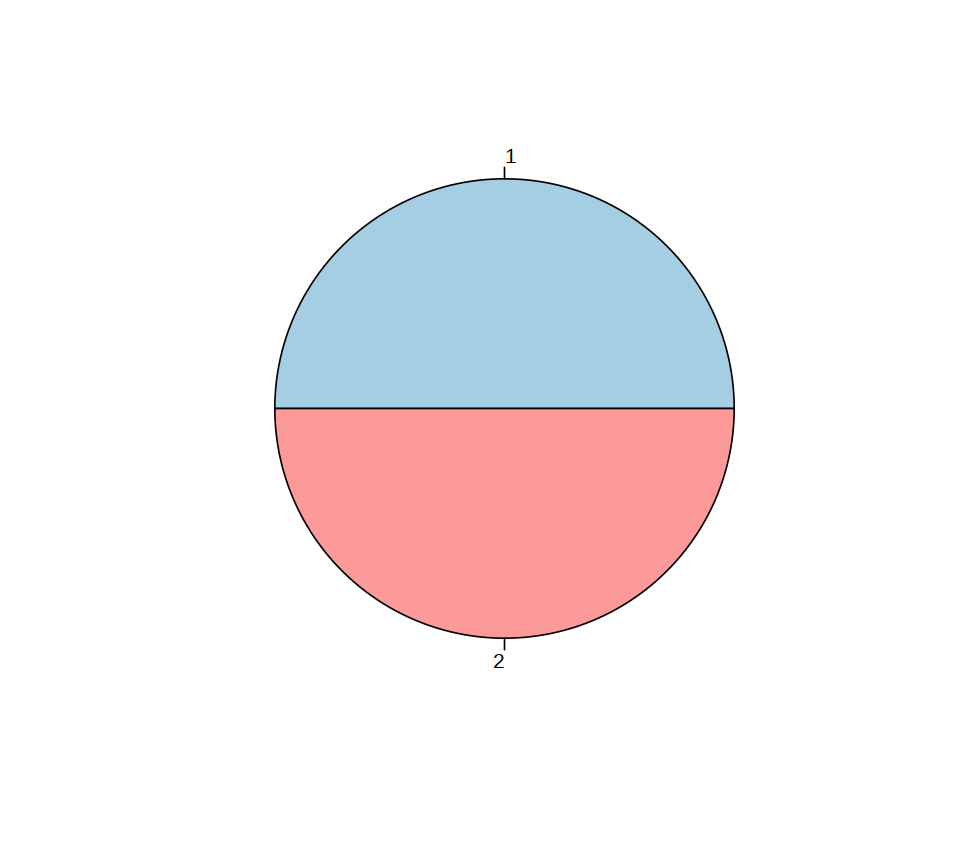

In [18]:
# make patient sample metadata and color assignments 
# http://applied-r.com/rcolorbrewer-palettes/

if (n_samples <= 4) {
    sampleColors <- brewer.pal(12, "Paired")
    sampleColors <- sampleColors[c(1,5,2,6)]
} else if (n_samples <= 12){
    sampleColors <- brewer.pal(n_samples, "Paired")
} else {
    vec_color1 <- colorRampPalette(brewer.pal(9, "Set1"))(n_samples/2)
    vec_color2 <- colorspace::lighten(vec_color1, amount=0.4) 
    sampleColors <- c(rbind(vec_color1, vec_color2))
}

sampleColors
length(sampleColors)

options(repr.plot.width=8.01, repr.plot.height=7.01)
pie(rep(1,n_samples), col=sampleColors) 


### epi

[1] "Epithelial cells" "Epi. Non-tumor"   "LEp_prog"         "LEp_secretory"   
 [5] "LEp"              "LEp_hormone"      "BEp"              "BEp_MaSCs"       
 [9] "BEp_myo"          "Epi. Unassigned"  "Epi. Tumor"       "Normal-like"     
[13] "NBL"              "Basal"            "CLow"             "Her2E"           
[17] "LumA"             "LumB"             "Keratinocytes"

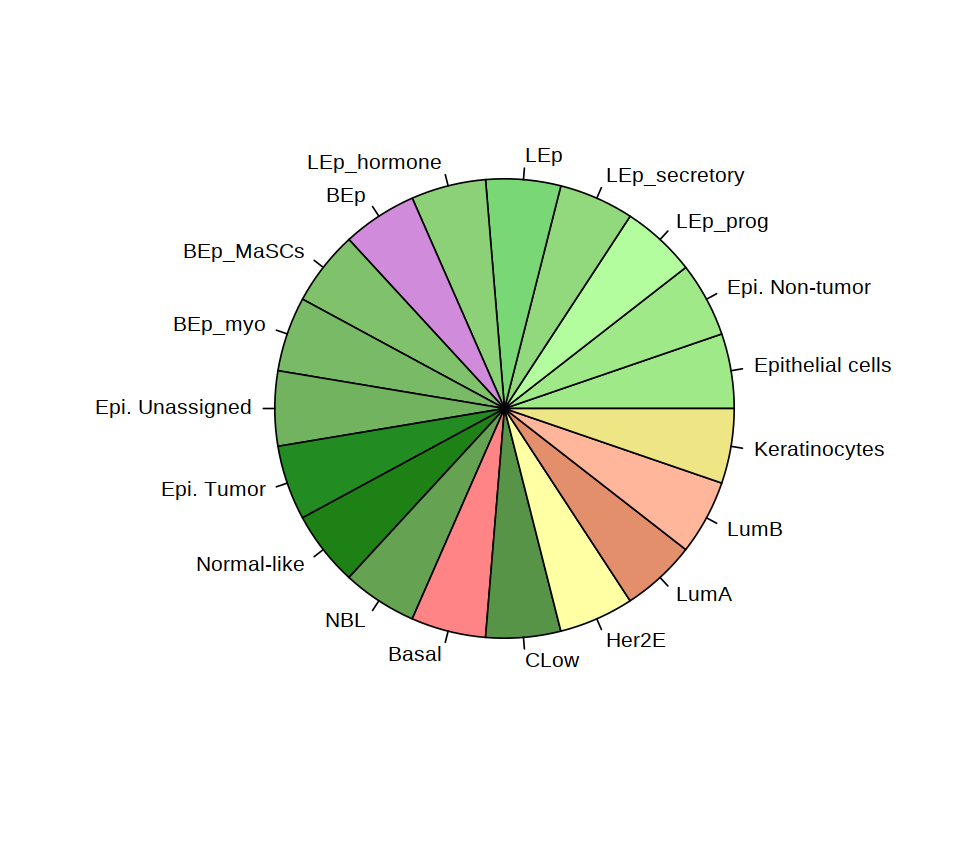

In [19]:
idx_epi <- grep(pattern_epi, names(nv_color))
names(nv_color)[idx_epi]
# http://applied-r.com/rcolorbrewer-palettes/
colors_epi <- RColorBrewer::brewer.pal(9, "Set1")
colors_epi <- colorspace::lighten(colors_epi, amount=0.4)

nv_color["Epi. Tumor"] <- "forestgreen"

nv_color["LEp_prog"] <- "#b4fd9e"
nv_color["LEp"] <- colors_epi[3]
nv_color["BEp"] <- colors_epi[4]

nv_color["Basal"] <- colors_epi[1]
nv_color["Her2E"] <- colors_epi[6]
nv_color["Her2"] <- colors_epi[6]
nv_color["LumA"] <- colors_epi[7]
nv_color["LumB"] <- colors_epi[5]
nv_color["Normal-like"] <- colorspace::darken(colors_epi[3], amount=0.4)

pie(rep(1, length(idx_epi)), col=nv_color[idx_epi],
       labels=names(nv_color)[idx_epi]) 


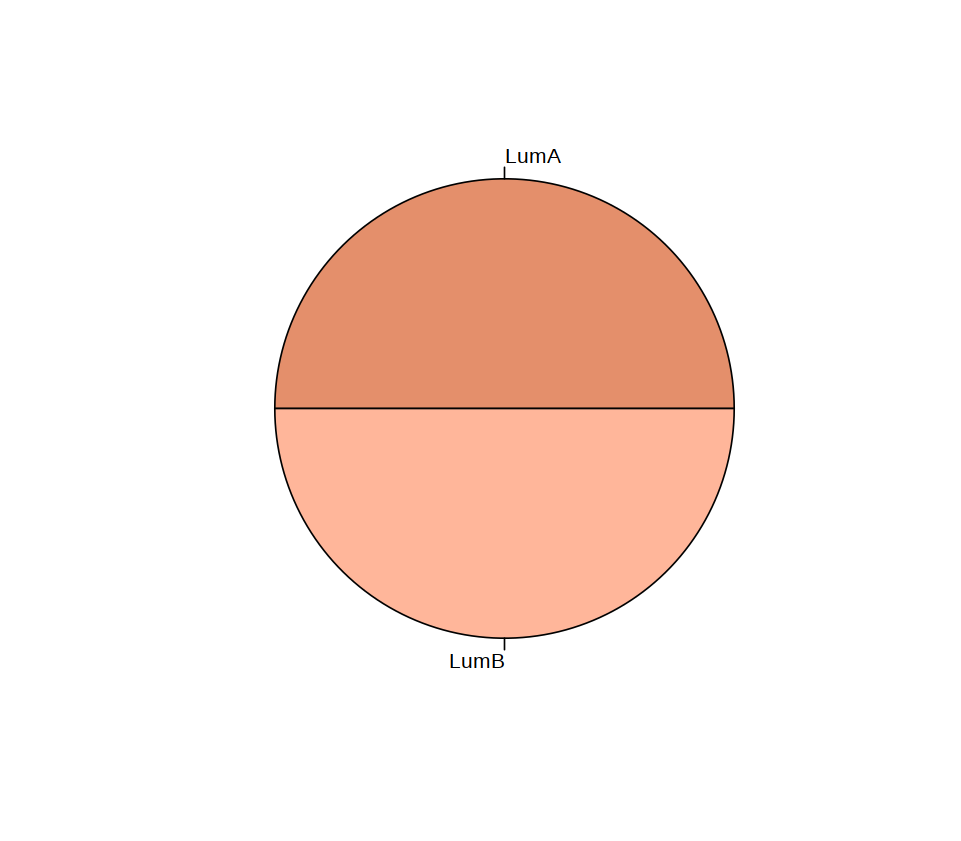

In [20]:
list_sort <- update_nv_color_cell_type(list_sort)
colors_epi <- list_sort$nv_color_cell_type

pie(rep(1, length(colors_epi)), col=colors_epi,
       labels=names(colors_epi)) 


### cell.type

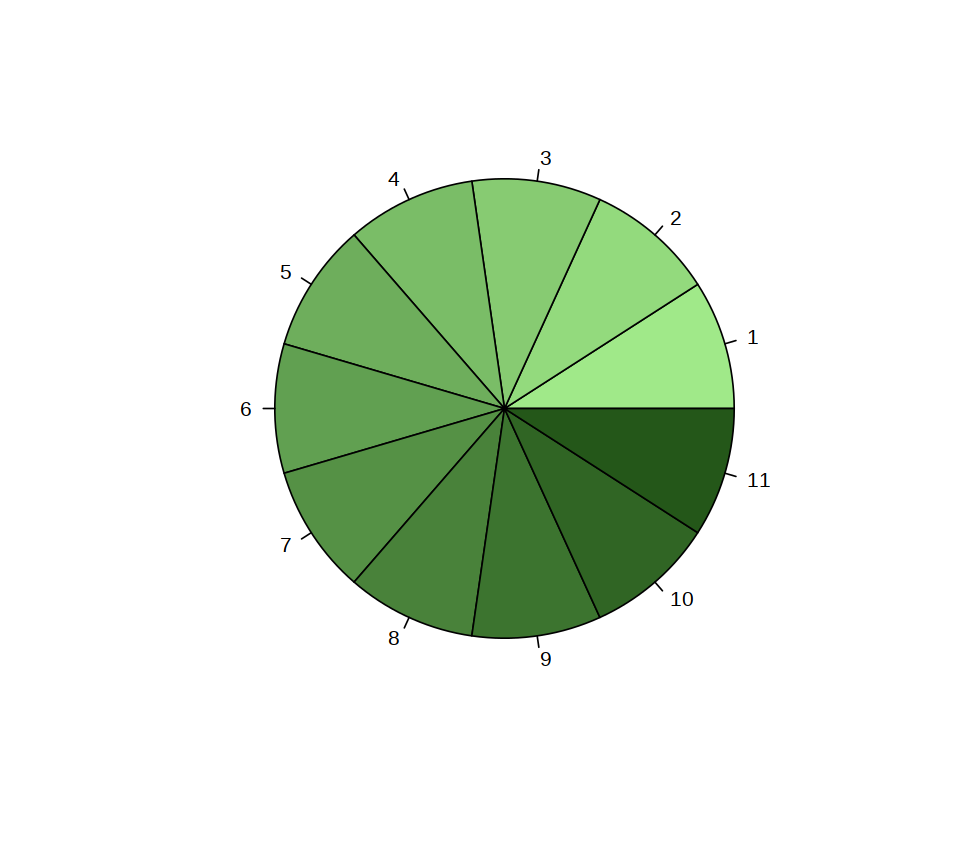

In [21]:
options(repr.plot.width=8.01, repr.plot.height=7.01)
pie(rep(1, length(list_sort$nv_color_cluster_type_ordered)),
    col=list_sort$nv_color_cluster_type_ordered) 


# DGE

## gmt

In [22]:

list_gmt <- list()
list_gmt[["h"]] <- read.gmt("reference/gmt/h.all.v6.1.symbols.gmt")
list_gmt[["unc_lccc"]] <- read.gmt("reference/gmt/pubmed21214954_human_gene_signatures.gmt")



## type_condition

In [23]:

method_dge <- "seurat_findmarkers_enricher"
dir_xlsx <- "xlsx"

list_genes_dn <- list()

# additional conditions 
genes <- NULL
str_cond1 <- NULL
str_cond_ref <- NULL
type_condition <- "none"


## cell line

In [24]:
sample1 <- "T47D_Tamoxifen"
sample_ref <- "T47D_Control"

th_log2fc_ = 0.25
th_padj_ = 0.01

min.pct_ = 0.25
min.diff.pct_ = -Inf
max.cells.per.ident_ = Inf
f_featureplot = FALSE
n_sampling = -1
# n_sampling=300
cluster_rows = FALSE

drug_name <- "tamoxifen"
pattern_sample1 <- NULL
pattern_sample_ref <- NULL

group_name1 <- sample1
group_name_ref <- sample_ref

col_cluster_types_ <- NULL
col_cell_types_ <- "cell.type"

## find markers

In [25]:
cat(sprintf("sample1=%s\n", sample1))
cat(sprintf("sample_ref=%s\n", sample_ref))

cat(sprintf("drug_name=%s\n", drug_name))
cat(sprintf("pattern_sample1=%s\n", pattern_sample1))
cat(sprintf("pattern_sample_ref=%s\n", pattern_sample_ref))

cat(sprintf("\t\tgroup_name1=%s\n", group_name1))
cat(sprintf("\t\tgroup_name_ref=%s\n", group_name_ref))
cat(sprintf("\t\tcol_cluster_types_=%s\n", col_cluster_types_))
cat(sprintf("\t\tcol_cell_types_=%s\n", col_cell_types_))

cat(sprintf("\t\tth_log2fc=%g\n", th_log2fc_))
cat(sprintf("\t\tth_padj=%g\n", th_padj_))
cat(sprintf("\t\tmin.pct=%g\n", min.pct_))
cat(sprintf("\t\tmin.diff.pct=%g\n", min.diff.pct_))
cat(sprintf("\t\tmax.cells.per.ident=%g\n", max.cells.per.ident_))
cat(sprintf("\t\tmethod_dge=%s\n", method_dge))

cat(sprintf("\t\ttype_condition=%s\n", type_condition))
cat(sprintf("\t\tgenes=%s\n", paste(genes, collapse = ", ")))
cat(sprintf("\t\tstr_cond1=%s\n", str_cond1))
cat(sprintf("\t\tstr_cond_ref=%s\n", str_cond_ref))



sample1=T47D_Tamoxifen
sample_ref=T47D_Control
drug_name=tamoxifen
		group_name1=T47D_Tamoxifen
		group_name_ref=T47D_Control
		col_cell_types_=cell.type
		th_log2fc=0.25
		th_padj=0.01
		min.pct=0.25
		min.diff.pct=-Inf
		max.cells.per.ident=Inf
		method_dge=seurat_findmarkers_enricher
		type_condition=none
		genes=


seurat_findmarkers_enricher         col_log2fc=avg_log2FC         col_pvalue=p_val         col_padj=p_val_adj         th_log2fc=0.25         th_padj=0.01

df_up

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,expr_min,expr_mean,expr_max
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
RPS29,0.000000e+00,0.5033383,1,1.000,0.000000e+00,0.000000,3.479241,4.702337
RPS27,6.902129e-296,0.5279653,1,1.000,1.412866e-291,0.000000,3.952087,5.383424
RPS28,1.096364e-277,0.5432672,1,1.000,2.244256e-273,0.000000,3.560273,4.942524
RPL34,2.387078e-246,0.5604793,1,0.999,4.886350e-242,0.000000,3.170508,4.672081
RPL37A,5.812193e-245,0.4580176,1,0.998,1.189756e-240,0.000000,3.213740,4.951160
RPL37,6.547629e-244,0.4065432,1,1.000,1.340300e-239,2.296541,3.851047,5.188366


[1] 90  8

df_dn

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,expr_min,expr_mean,expr_max
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
MT-ATP6,3.682745e-164,-0.7229942,0.999,0.999,7.538578e-160,0,3.9814516,5.805141
FMN1,3.977448e-141,-0.4199418,0.704,0.931,8.141837e-137,0,0.3480963,2.098238
NDFIP1,3.021772e-131,-0.3356485,0.948,0.988,6.185568e-127,0,0.6991458,2.343052
SRP9,1.547235e-130,-0.3570587,0.988,0.998,3.167191e-126,0,1.1191913,2.278952
IL6ST,3.016367e-129,-0.4440205,0.850,0.961,6.174503e-125,0,0.5394353,1.981163
MRFAP1,9.310181e-127,-0.3181005,0.994,0.998,1.905794e-122,0,1.1701247,2.952899


[1] 110   8

up h

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
HALLMARK_CHOLESTEROL_HOMEOSTASIS,HALLMARK_CHOLESTEROL_HOMEOSTASIS,HALLMARK_CHOLESTEROL_HOMEOSTASIS,11/38,74/4386,1.228406e-11,4.053740e-10,3.491259e-10,SQLE/MVD/DHCR7/HMGCS1/ACTG1/IDI1/SCD/FDFT1/TMEM97/HMGCR/FDPS,11
HALLMARK_MTORC1_SIGNALING,HALLMARK_MTORC1_SIGNALING,HALLMARK_MTORC1_SIGNALING,14/38,200/4386,3.937846e-10,6.497445e-09,5.595886e-09,SQLE/INSIG1/DHCR7/SQSTM1/DDIT3/HMGCS1/NUPR1/IDI1/SCD/HSPA5/TMEM97/HMGCR/BHLHE40/MTHFD2,14
HALLMARK_ANDROGEN_RESPONSE,HALLMARK_ANDROGEN_RESPONSE,HALLMARK_ANDROGEN_RESPONSE,7/38,101/4386,1.957838e-05,2.153622e-04,1.854794e-04,INSIG1/SAT1/HMGCS1/IDI1/SCD/HMGCR/DNAJB9,7
HALLMARK_UNFOLDED_PROTEIN_RESPONSE,HALLMARK_UNFOLDED_PROTEIN_RESPONSE,HALLMARK_UNFOLDED_PROTEIN_RESPONSE,7/38,113/4386,4.077355e-05,3.363818e-04,2.897068e-04,RPS14/HSPA5/HERPUD1/HYOU1/EIF4EBP1/MTHFD2/DNAJB9,7
HALLMARK_P53_PATHWAY,HALLMARK_P53_PATHWAY,HALLMARK_P53_PATHWAY,6/38,200/4386,6.782903e-03,4.476716e-02,3.855545e-02,RPL36/SAT1/DDIT3/NUPR1/RPS12/MKNK2,6


[1] 5 9

up unc_lccc

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
Ribosomal_Cluster_BMC.Med.Genomics.2011_PMID.21214954,Ribosomal_Cluster_BMC.Med.Genomics.2011_PMID.21214954,Ribosomal_Cluster_BMC.Med.Genomics.2011_PMID.21214954,18/85,50/19982,4.919926e-31,7.871882e-29,6.370010e-29,RPS29/RPS28/RPL37A/RPL37/RPL39/RPL36/RPL35A/RPS21/RPLP2/RPS8/RPL35/RPS15A/RPL12/RPL32/RPS24/RPS12/RPS13/RPL11,18
MRibosomal_BMC.Med.Genomics.2011_PMID.21214954,MRibosomal_BMC.Med.Genomics.2011_PMID.21214954,MRibosomal_BMC.Med.Genomics.2011_PMID.21214954,9/85,23/19982,2.295479e-16,1.836383e-14,1.486020e-14,RPL39/RPL36/RPL41/RPL22L1/RPL35/RPS15/RPS24/RPS13/RPL10,9
Duke_Module07_glucosedepletion_Mike_PMID.20335537,Duke_Module07_glucosedepletion_Mike_PMID.20335537,Duke_Module07_glucosedepletion_Mike_PMID.20335537,5/85,27/19982,9.272832e-08,4.945510e-06,4.001959e-06,SAT1/HERPUD1/HYOU1/KLHL24/DNAJB9,5
Duke_Module02_akt_Mike_PMID.20335537,Duke_Module02_akt_Mike_PMID.20335537,Duke_Module02_akt_Mike_PMID.20335537,6/85,77/19982,9.225306e-07,3.690122e-05,2.986086e-05,INSIG1/FTL/SCD/FDFT1/TMEM97/BHLHE40,6
MCF7.E2.induced.genes_JCO.2006_PMID.16505416,MCF7.E2.induced.genes_JCO.2006_PMID.16505416,MCF7.E2.induced.genes_JCO.2006_PMID.16505416,9/85,290/19982,3.959407e-06,1.267010e-04,1.025278e-04,SQLE/INSIG1/MSMO1/DHCR7/IDI1/SCD/FDFT1/SEC61B/HMGCR,9
JANES_Oscillation_JUND_KRT5_Nat.Cell.Biol.2014_PMID.24658685,JANES_Oscillation_JUND_KRT5_Nat.Cell.Biol.2014_PMID.24658685,JANES_Oscillation_JUND_KRT5_Nat.Cell.Biol.2014_PMID.24658685,4/85,35/19982,1.443734e-05,3.849959e-04,3.115427e-04,RPS29/TMEM258/RPS21/S100A6,4


[1] 19  9

down h

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
HALLMARK_ESTROGEN_RESPONSE_EARLY,HALLMARK_ESTROGEN_RESPONSE_EARLY,HALLMARK_ESTROGEN_RESPONSE_EARLY,16/67,200/4386,2.763141e-08,1.160519e-06,1.017999e-06,IL6ST/FKBP4/MYBL1/OLFM1/B4GALT1/KRT19/ARL3/IGFBP4/TPBG/KRT15/CA12/GREB1/FKBP5/PGR/XBP1/STC2,16
HALLMARK_ESTROGEN_RESPONSE_LATE,HALLMARK_ESTROGEN_RESPONSE_LATE,HALLMARK_ESTROGEN_RESPONSE_LATE,14/67,200/4386,1.230287e-06,2.583603e-05,2.266318e-05,IL6ST/FKBP4/OLFM1/KRT19/ARL3/IGFBP4/TPBG/CA12/FKBP5/PGR/XBP1/PRLR/PDCD4/NMU,14
HALLMARK_E2F_TARGETS,HALLMARK_E2F_TARGETS,HALLMARK_E2F_TARGETS,11/67,200/4386,1.827412e-04,1.918783e-03,1.683143e-03,TFRC/PRDX4/SNRPB/RBBP7/CENPE/H2AFZ/STMN1/CCNB2/BIRC5/PTTG1/UBE2S,11
HALLMARK_MYC_TARGETS_V1,HALLMARK_MYC_TARGETS_V1,HALLMARK_MYC_TARGETS_V1,11/67,200/4386,1.827412e-04,1.918783e-03,1.683143e-03,RPS10/PSMA2/ERH/LDHA/CCT3/SRSF7/PRDX4/HNRNPA2B1/VDAC3/CCT5/H2AFZ,11
HALLMARK_G2M_CHECKPOINT,HALLMARK_G2M_CHECKPOINT,HALLMARK_G2M_CHECKPOINT,9/67,200/4386,3.051633e-03,2.563372e-02,2.248572e-02,SFPQ/H2AFV/CENPE/H2AFZ/STMN1/CCNB2/BIRC5/PTTG1/UBE2S,9


[1] 5 9

down unc_lccc

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
Wirapati_Proliferation_Breast.Cancer.Res.2008_PMID.18662380,Wirapati_Proliferation_Breast.Cancer.Res.2008_PMID.18662380,Wirapati_Proliferation_Breast.Cancer.Res.2008_PMID.18662380,17/104,354/19982,3.859248e-12,9.223603e-10,6.499786e-10,MRPL13/GNG11/HNRNPA2B1/CCT5/JPT1/H2AFV/ARL6IP1/CENPE/H2AFZ/KNSTRN/STMN1/ZWINT/ECT2/CCNB2/BIRC5/PTTG1/UBE2S,17
UNC_HS_Green18_BMC.Med.Genomics.2011_PMID.21214954,UNC_HS_Green18_BMC.Med.Genomics.2011_PMID.21214954,UNC_HS_Green18_BMC.Med.Genomics.2011_PMID.21214954,12/104,158/19982,3.620344e-11,4.326311e-09,3.048710e-09,IL6ST/IGFBP4/TPBG/KRT15/SGK3/CA12/GREB1/TRPS1/PGR/PDCD4/GATA3/STC2,12
MCF7.E2.induced.genes_JCO.2006_PMID.16505416,MCF7.E2.induced.genes_JCO.2006_PMID.16505416,MCF7.E2.induced.genes_JCO.2006_PMID.16505416,14/104,290/19982,3.322132e-10,2.646632e-08,1.865056e-08,FMN1/TFRC/FKBP4/MYBL1/OLFM1/B4GALT1/IGFBP4/KRT15/SGK3/CA12/GREB1/PGR/XBP1/JPT1,14
UNC_HS_Green8_BMC.Med.Genomics.2011_PMID.21214954,UNC_HS_Green8_BMC.Med.Genomics.2011_PMID.21214954,UNC_HS_Green8_BMC.Med.Genomics.2011_PMID.21214954,13/104,314/19982,9.448583e-09,5.645528e-07,3.978351e-07,IL6ST/KRT19/IGFBP4/TPBG/REEP5/CA12/GREB1/MAGED2/TMBIM4/PGR/XBP1/GATA3/STC2,13
Proliferation_Cluster_BMC.Med.Genomics.2011_PMID.21214954,Proliferation_Cluster_BMC.Med.Genomics.2011_PMID.21214954,Proliferation_Cluster_BMC.Med.Genomics.2011_PMID.21214954,9/104,121/19982,1.374069e-08,6.568051e-07,4.628444e-07,CCT5/CENPE/H2AFZ/STMN1/ZWINT/ECT2/CCNB2/PTTG1/UBE2S,9
Duke_Module17_pr_Mike_PMID.20335537,Duke_Module17_pr_Mike_PMID.20335537,Duke_Module17_pr_Mike_PMID.20335537,7/104,62/19982,3.279285e-08,1.306249e-06,9.205011e-07,IL6ST/FKBP4/ARL3/CA12/GREB1/GOLM1/GATA3,7


[1] 54  9

filename_xlsx: xlsx/er+bc-cell-line_T47D_Control_vs_T47D_Tamoxifen_Tumor_cells.xlsx

filename_figure: heatmap_er+bc-cell-line_T47D_Control_vs_T47D_Tamoxifen_Tumor_cells_zscore

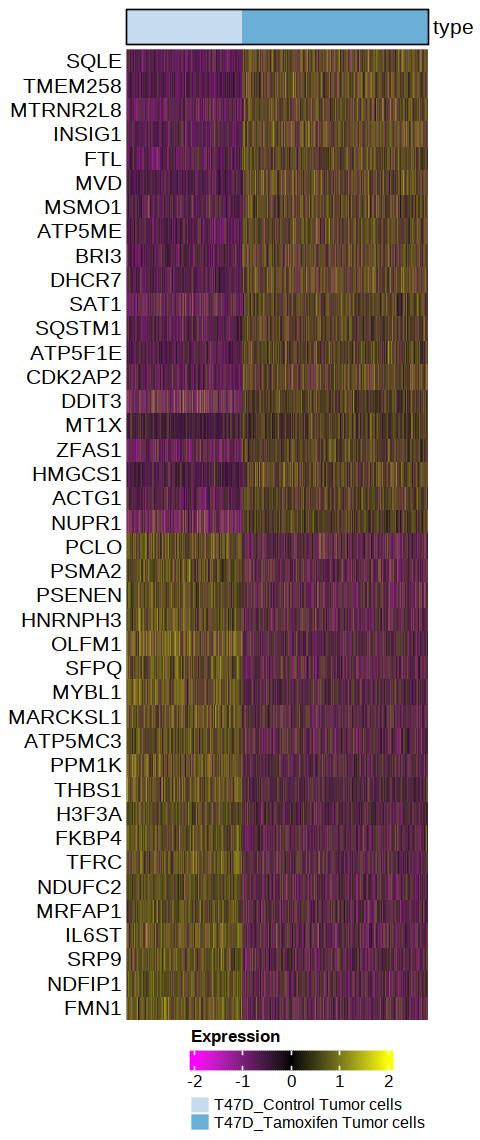

In [26]:

list_markers <- find_markers(rna, sample1 = sample1,
                        sample_ref = sample_ref,
                        pattern_sample1 = pattern_sample1,
                        pattern_sample_ref = pattern_sample_ref,
                             
                        # pattern_tumor_epi     
                        pattern_cell_type1 = pattern_tumor_epi,
                        pattern_cell_type_ref = pattern_tumor_epi,
                             
                        genes = genes,
                        str_cond1 = str_cond1,
                        str_cond_ref = str_cond_ref,
                             
                        group_name1 = sprintf("%s Tumor cells", group_name1),
                        group_name_ref = sprintf("%s Tumor cells", group_name_ref),
                        col_cluster_types = col_cluster_types_,
                        col_cell_types = col_cell_types_,
                        th_log2fc = th_log2fc_,
                        th_padj = th_padj_, 
                        min.pct = min.pct_,
                        min.diff.pct = min.diff.pct_,
                        max.cells.per.ident = max.cells.per.ident_,
                        method_dge = method_dge)

str_condition_tmp <- sprintf("%s_%s_vs_%s_Tumor cells",
                             str_condition,
                             group_name_ref, group_name1)

if (type_condition != "none") {
          str_condition_tmp <- sprintf("%s_%s", str_condition_tmp, type_condition)
}

list_ea <- execute_enrichment_analysis(list_markers$markers,
                        str_condition_tmp,
                        th_log2fc = th_log2fc_,
                        th_padj = th_padj_,
                        method_dge = method_dge,
                        dir_xlsx = dir_xlsx,       
                        n_log = 1)


genes_up <- rownames(list_ea$df_up)
genes_dn <- rownames(list_ea$df_dn)
list_genes_dn[["Epi"]] <- genes_dn

if (f_featureplot) {
    gg <- featureplot_enrichment_analysis(rna,
                list_ea,
                str_condition_tmp)
}

list_out_heatmap <- heatmap_enrichment_analysis(list_markers,
                    list_ea,
                    str_condition_tmp,
                    pattern_gene_removal="^MT-|^RPS|^RPL",
                    n_sampling=n_sampling,
                    cluster_rows=cluster_rows)



# session info

In [27]:
writeLines(capture.output(sessionInfo()), "txt/sessionInfo.txt")


# reference

https://satijalab.org/seurat/

